In [ ]:
import random
import os
import numpy as np

from PIL import Image

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler

import torchvision
import torchvision.transforms as transforms
from torchvision import utils, models

def is_image(filename):
    return any(filename.endswith(extension) for extension in [".jpg", ".jpeg", ".png"])

class IndexedDataset(Dataset):

    def __init__(self, dir_path, transform=None, test=False):
        '''
        Args:
        - dir_path (string): path to the directory containing images
        - transform (torchvision.transforms.) (default=None)
        - test (boolean): True for labeled images, False otherwise (default=False)
        '''

        self.dir_path = dir_path
        self.transform = transform
        
        image_filenames = []
        for (dirpath, dirnames, filenames) in os.walk(dir_path):
            image_filenames += [os.path.join(dirpath, file) for file in filenames if is_image(file)]
        self.image_filenames = image_filenames    
        
        # We assume that in the beginning, the entire dataset is unlabeled, unless it is flagged as 'test':
        if test:
            # The image's label is given by the first digit of its subdirectory's name
            # E.g. the label for the image file `./dogs/train/6_great_dane/n02109047_22481.jpg` is 6
            self.labels = [int(f[len(self.dir_path)+1]) for f in self.image_filenames]
            self.unlabeled_mask = np.zeros(len(self.image_filenames))
        else:
            self.labels =[0]*len(self.image_filenames)
            self.unlabeled_mask = np.ones(len(self.image_filenames))

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):

        img_name = self.image_filenames[idx]
        image = Image.open(img_name)

        if self.transform:
            image = self.transform(image)

        return image, self.labels[idx], idx
    
    # Display the image [idx] and its filename
    def display(self, idx):
        img_name = self.image_filenames[idx]
        print(img_name)
        img=mpimg.imread(img_name)
        imgplot = plt.imshow(img)
        plt.show()
        return
    
    # Set the label of image [idx] to 'new_label'
    def update_label(self, idx, new_label):
        self.labels[idx] = new_label
        self.unlabeled_mask[idx] = 0
        return
    
    # Set the label of image [idx] to that read from its filename
    def label_from_filename(self, idx):
        self.labels[idx] = int(self.image_filenames[idx][len(self.dir_path)+1])
        self.unlabeled_mask[idx] = 0
        return
        
'''
Each query strategy below returns a list of len=query_size with indices of 
samples that are to be queried.

Arguments:
- model (torch.nn.Module): not needed for `random_query`
- device (torch.device): not needed for `random_query`
- dataloader (torch.utils.data.DataLoader)
- query_size (int): number of samples to be queried for labels (default=10)

'''
def random_query(data_loader, query_size=10):
    
    sample_idx = []
    
    # Because the data has already been shuffled inside the data loader,
    # we can simply return the `query_size` first samples from it
    for batch in data_loader:
        
        _, _, idx = batch
        sample_idx.extend(idx.tolist())

        if len(sample_idx) >= query_size:
            break
    
    return sample_idx[0:query_size]

def least_confidence_query(model, device, data_loader, query_size=10):

    confidences = []
    indices = []
    
    model.eval()
    
    with torch.no_grad():
        for batch in data_loader:
        
            data, _, idx = batch
            logits = model(data.to(device))
            probabilities = F.softmax(logits, dim=1)
            
            # Keep only the top class confidence for each sample
            most_probable = torch.max(probabilities, dim=1)[0]
            confidences.extend(most_probable.cpu().tolist())
            indices.extend(idx.tolist())
            
    conf = np.asarray(confidences)
    ind = np.asarray(indices)
    sorted_pool = np.argsort(conf)
    # Return the indices corresponding to the lowest `query_size` confidences
    return ind[sorted_pool][0:query_size]

def margin_query(model, device, data_loader, query_size=10):
    
    margins = []
    indices = []
    
    model.eval()
    
    with torch.no_grad():
        for batch in data_loader:
        
            data, _, idx = batch
            logits = model(data.to(device))
            probabilities = F.softmax(logits, dim=1)
            
            # Select the top two class confidences for each sample
            toptwo = torch.topk(probabilities, 2, dim=1)[0]
            
            # Compute the margins = differences between the two top confidences
            differences = toptwo[:,0]-toptwo[:,1]
            margins.extend(torch.abs(differences).cpu().tolist())
            indices.extend(idx.tolist())

    margin = np.asarray(margins)
    index = np.asarray(indices)
    sorted_pool = np.argsort(margin)
    # Return the indices corresponding to the lowest `query_size` margins
    return index[sorted_pool][0:query_size]

'''
Queries the oracle (user, if `interactive` is set to True) for  labels for'query_size' 
samples using 'query_strategy'

Arguments:
- model (torch.nn.Module)
- device: torch.device (CPU or GPU)
- dataset (torch.utils.data.DataSet)
- query_size (int): number of samples to be queried for labels (default=10)
- query_strategy (string): one of ['random', 'least_confidence', 'margin'], 
                           otherwise defaults to 'random'
- interactive (bool): if True, prompts the user to input the images' labels manually
                      if False, reads the labels from filenames (default=True)
- pool_size (int): when > 0, the size of the randomly selected pool from the unlabeled_loader to consider
                   (otherwise defaults to considering all of the associated data)
- batch_size (int): default=128
- num_workers (int): default=4

Modifies:
- dataset: edits the labels of samples that have been queried; updates dataset.unlabeled_mask
'''

def query_the_oracle(model, device, dataset, query_size=10, query_strategy='random', 
                     interactive=True, pool_size=0, batch_size=128, num_workers=4):
    
    unlabeled_idx = np.nonzero(dataset.unlabeled_mask)[0]
    
    # Select a pool of samples to query from
    if pool_size > 0:    
        pool_idx = random.sample(range(1, len(unlabeled_idx)), pool_size)
        pool_loader = DataLoader(dataset, batch_size=batch_size, num_workers=num_workers,
                                              sampler=SubsetRandomSampler(unlabeled_idx[pool_idx]))
    else:
        pool_loader = DataLoader(dataset, batch_size=batch_size, num_workers=num_workers,
                                              sampler=SubsetRandomSampler(unlabeled_idx))
       
    if query_strategy == 'margin':
        sample_idx = margin_query(model, device, pool_loader, query_size)
    elif query_strategy == 'least_confidence':
        sample_idx = least_confidence_query(model, device, pool_loader, query_size)
    else:
        sample_idx = random_query(pool_loader, query_size)
    
    # Query the samples, one at a time
    for sample in sample_idx:
        
        if interactive:
            dataset.display(sample)
            print("What is the class of this image?")
            new_label = int(input())
            dataset.update_label(sample, new_label)
            
        else:
            dataset.label_from_filename(sample)
        
def train(model, device, train_loader, optimizer, criterion):
    
    model.train()
    
    epoch_loss = 0
    
    for batch in train_loader:
        
        data, target, _ = batch
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output.squeeze(), target.squeeze())
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        
    return epoch_loss

def test(model, device, test_loader, criterion, display=False):
    
    model.eval()
    
    test_loss = 0
    n_correct = 0
    
    one = torch.ones(1, 1).to(device)
    zero = torch.zeros(1, 1).to(device)
    
    with torch.no_grad():
        for batch in test_loader:
            
            data, target, _ = batch
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output.squeeze(), target.squeeze()).item()  # sum up batch loss
            prediction = output.argmax(dim=1, keepdim=True)
            torch.where(output.squeeze()<0.5, zero, one)  # get the index of the max log-probability
            n_correct += prediction.eq(target.view_as(prediction)).sum().item()

    test_loss /= len(test_loader.dataset) 
    
    if display:
        print('Accuracy on the test set: ', (100. * n_correct / len(test_loader.dataset)))
    return test_loss, (100. * n_correct / len(test_loader.dataset))
 

Train set size:  1132
Test set size:  500
Accuracy on the test set:  37.8
./dogs/train/0_chihuahua/n02085620_6931.jpg


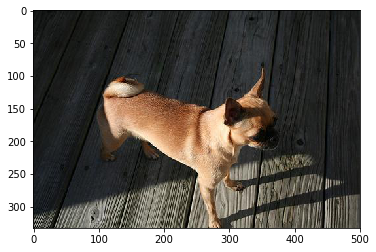

What is the class of this image?
0
./dogs/train/6_great_dane/n02109047_8139.jpg


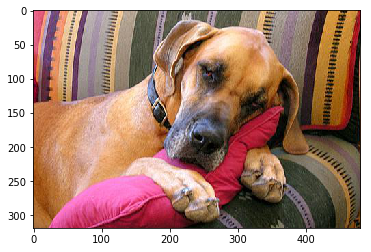

What is the class of this image?


In [ ]:
np.random.seed(42)
random.seed(10)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(999)

train_dir = './dogs/train'
test_dir = './dogs/test'

device = torch.device("cuda")

train_set = IndexedDataset(train_dir, transform=transforms.Compose([transforms.Resize((224, 224)), 
                                                                transforms.ToTensor()]))
test_set = IndexedDataset(test_dir, transform=transforms.Compose([transforms.Resize((224, 224)), 
                                                                transforms.ToTensor()]), test=True) 
test_loader = DataLoader(test_set, batch_size=1024, shuffle=False, num_workers=10)

print('Train set size: ', len(train_set))
print('Test set size: ', len(test_set))

# Number of classes in the classification problem
n_classes = 10

# The classifier is a pre-trained ResNet18 with a random top layer dim = n_classes
classifier = models.resnet18(pretrained=True)
num_ftrs = classifier.fc.in_features
classifier.fc = nn.Linear(num_ftrs, n_classes)
classifier = classifier.to(device) 

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(classifier.parameters(), lr=0.01, momentum=0.9, dampening=0, weight_decay=0.0001)
        
# Label the initial subset
query_the_oracle(classifier, device, train_set, query_size=20, interactive=False, query_strategy='random', pool_size=0)
  
# How many times should the oracle be queried
num_queries = 3

batch_size = 1024

# Pre-train on the initial subset
labeled_idx = np.where(train_set.unlabeled_mask == 0)[0]
labeled_loader = DataLoader(train_set, batch_size=batch_size, num_workers=10, 
                            sampler=SubsetRandomSampler(labeled_idx))
previous_test_acc = 0
current_test_acc = 1
while current_test_acc > previous_test_acc:
    previous_test_acc = current_test_acc
    train_loss = train(classifier, device, labeled_loader, optimizer, criterion)
    _, current_test_acc = test(classifier, device, test_loader, criterion)


test(classifier, device, test_loader, criterion, display=True)

for query in range(num_queries):
    
    # Query the oracle for more labels
    query_the_oracle(classifier, device, train_set, query_size=5, query_strategy='margin', interactive=True, pool_size=0)
    
    # Train the model on the data that has been labeled so far:
    labeled_idx = np.where(train_set.unlabeled_mask == 0)[0]
    labeled_loader = DataLoader(train_set, batch_size=batch_size, num_workers=10, 
                                sampler=SubsetRandomSampler(labeled_idx))
    previous_test_acc = 0
    current_test_acc = 1
    while current_test_acc > previous_test_acc:
        previous_test_acc = current_test_acc
        train_loss = train(classifier, device, labeled_loader, optimizer, criterion)
        _, current_test_acc = test(classifier, device, test_loader, criterion)


    # Test the model:
    test(classifier, device, test_loader, criterion, display=True)
    